<a href="https://colab.research.google.com/github/cocoisland/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module4-Model%20Diagnostics/Model_Diagnostics_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

In [205]:
##### Your Code Here #####
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

url='https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'
df = pd.read_csv(url, na_values='?')
print(df.columns, "\n")
df.head()


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
# Separate out the numeric from non-numeric features.

#df.dtypes
df_num = df.select_dtypes(include=['int64','float64']).copy()
df_obj = df.select_dtypes(include=['object']).copy()

In [115]:
print(df_num.columns, "\n")
df_num.head()


Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object') 



,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


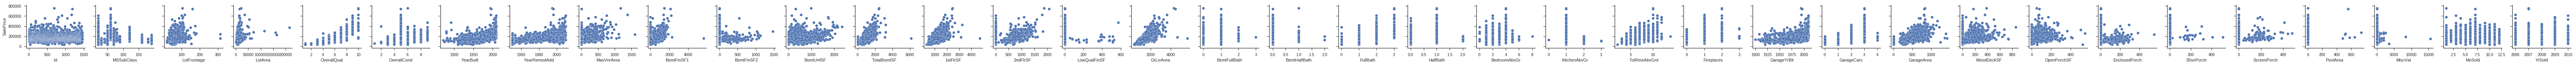

In [207]:
sns.set(style="ticks", color_codes=True)

# Generate a list of column headers not including price
x_columns = df_num.columns.drop('SalePrice')

# Only plot the scatterplot of x variables with our y variable
fig = sns.pairplot(data=df_num, y_vars=['SalePrice'], x_vars=x_columns)

In [0]:
features=['LotFrontage','LotArea','OverallQual','TotalBsmtSF','1stFlrSF','GrLivArea','TotRmsAbvGrd','GarageArea','SalePrice']

Text(0.5, 1.0, 'Sale Price by Lot Area')

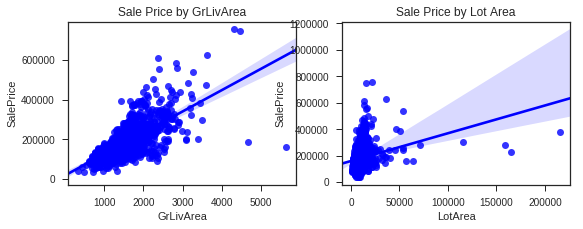

In [117]:
# Plot regplot GrLivArea

fig, axs = plt.subplots(1,2, figsize=(9,3))
sns.regplot(ax=axs[0], x='GrLivArea', y='SalePrice', data=df_num, color='blue').set_title('Sale Price by GrLivArea')
sns.regplot(ax=axs[1], x='LotArea', y='SalePrice', data=df_num, color='blue').set_title('Sale Price by Lot Area')

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

In [208]:
##### Your Code Here #####

df_num=df_num[features]

df_num.isna().sum()

LotFrontage     259
LotArea           0
OverallQual       0
TotalBsmtSF       0
1stFlrSF          0
GrLivArea         0
TotRmsAbvGrd      0
GarageArea        0
SalePrice         0
dtype: int64

In [209]:
df_num.LotFrontage.fillna(df_num.LotFrontage.mean(), inplace=True)
df_num.isna().sum()

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


LotFrontage     0
LotArea         0
OverallQual     0
TotalBsmtSF     0
1stFlrSF        0
GrLivArea       0
TotRmsAbvGrd    0
GarageArea      0
SalePrice       0
dtype: int64

In [210]:
# Use Statsmodels to run a regression

# This is like using np.ones to add a vector of ones
X=df_num.copy()
X=X.drop(['SalePrice'], axis=1)

y=df_num.SalePrice

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     583.6
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        03:18:20   Log-Likelihood:                -17493.
No. Observations:                1460   AIC:                         3.500e+04
Df Residuals:                    1451   BIC:                         3.505e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -1.05e+05   6301.334    -16.666   

## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

Coefficient Standard errors is the standard deviation of the coefficient, the amount it varies across cases. It is a measure of precision of the estimate of the coefficient. Standard error of coefficient is always positive. The smaller the standard error,  the more precise the estimate. Dividing the coefficient by its standard error, gives the t-statistics.

P-value greater than 0.05 indicates the null hypothesis is valid that the coefficient is useless and has not influenced on the dependent y-value. Hence P-value less than 0.05, voids the null hypothesis and suggests coefficient has influenced on the output of dependent y-value.



## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [211]:
##### Your Code Here #####
# # Lets remove outliers 

print(df_num.shape)

df_num=df_num[(np.abs(stats.zscore(df_num)) < 3).all(axis=1)]

print(df_num.shape)

(1460, 9)
(1389, 9)


In [212]:
# Statsmodel after removing outlier
X=df_num.copy()
X=X.drop(['SalePrice'], axis=1)

y=df_num.SalePrice

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     752.9
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        03:19:07   Log-Likelihood:                -16202.
No. Observations:                1389   AIC:                         3.242e+04
Df Residuals:                    1380   BIC:                         3.247e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.245e+04   4995.815    -18.506   

## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

In [213]:
##### Your Code Here #####

# Statsmodel with log transformation of y
X=df_num.copy()
X=X.drop(['SalePrice'], axis=1)

y=np.log(df_num.SalePrice)

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     748.1
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        03:19:22   Log-Likelihood:                 579.95
No. Observations:                1389   AIC:                            -1142.
Df Residuals:                    1380   BIC:                            -1095.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.5005      0.028    371.220   

## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [230]:
##### Your Code Here #####
from statsmodels.stats.outliers_influence import variance_inflation_factor

print(X.columns, '\n\n')

vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'TotalBsmtSF', '1stFlrSF',
       'TotRmsAbvGrd', 'GarageArea', 'LotFrontage_sq', 'LotArea_sq'],
      dtype='object') 


[151.22204749692787, 80.0768606992813, 35.087614754029396, 25.729933894189937, 37.315946455046166, 27.00107421644122, 9.946211686817975, 42.32428692859359, 18.21994815369647]


In [215]:
# remove const due to high Variance Inflation factor, high collinearity
X=X.drop(['const'], axis=1)

#statsmodel after dropping const from X
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     9535.
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        03:20:56   Log-Likelihood:                -2624.3
No. Observations:                1389   AIC:                             5265.
Df Residuals:                    1381   BIC:                             5306.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
LotFrontage      0.0325      0.003     11.680   

## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

In [216]:
##### Your Code Here #####
X.corr()

,LotFrontage,LotArea,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea
LotFrontage,1.000000,0.515057,0.205761,0.316185,0.374335,0.308927,0.302844,0.321399
LotArea,0.515057,1.000000,0.135464,0.278287,0.363978,0.331405,0.293917,0.270836
OverallQual,0.205761,0.135464,1.000000,0.501856,0.416184,0.565531,0.386971,0.542364
TotalBsmtSF,0.316185,0.278287,0.501856,1.000000,0.790758,0.339540,0.205379,0.449629
1stFlrSF,0.374335,0.363978,0.416184,0.790758,1.000000,0.462039,0.335912,0.446562
GrLivArea,0.308927,0.331405,0.565531,0.339540,0.462039,1.000000,0.813354,0.439904
TotRmsAbvGrd,0.302844,0.293917,0.386971,0.205379,0.335912,0.813354,1.000000,0.298874
GarageArea,0.321399,0.270836,0.542364,0.449629,0.446562,0.439904,0.298874,1.000000


## 2.3 If you have variables with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

In [217]:
##### Dropping GrLivArea for VIF 4.13 and covariance 0.81 with TotRmsAbvGrd
# Little effect on std error.
# Reduce 
X=X.drop(['GrLivArea'], axis=1)

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     9619.
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        03:21:21   Log-Likelihood:                -2709.8
No. Observations:                1389   AIC:                             5434.
Df Residuals:                    1382   BIC:                             5470.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
LotFrontage      0.0392      0.003     13.483   

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [218]:
# fitting model with Robust Standard Errors to address Heteroskedasticity

model = sm.OLS(y, X).fit(cov_type='HC3')
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     9741.
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        03:21:33   Log-Likelihood:                -2709.8
No. Observations:                1389   AIC:                             5434.
Df Residuals:                    1382   BIC:                             5470.
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
LotFrontage      0.0392      0.003     13.643   

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

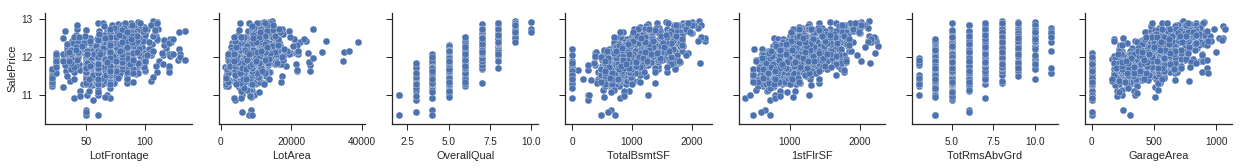

In [224]:
sns.set(style="ticks", color_codes=True)

# Generate a list of column headers
x_columns = X.columns

X1 = X.copy()
X1['SalePrice']=y

# Only plot the scatterplot of x variables with our y variable
fig = sns.pairplot(data=X1, y_vars=['SalePrice'], x_vars=x_columns)

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

In [225]:
X.columns


Index(['LotFrontage', 'LotArea', 'OverallQual', 'TotalBsmtSF', '1stFlrSF',
       'TotRmsAbvGrd', 'GarageArea'],
      dtype='object')

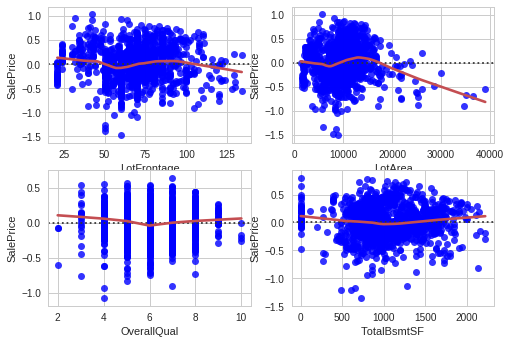

In [226]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(ncols=2, nrows=2)
sns.residplot(X['LotFrontage'], y, lowess=True, color="r", ax=axs[0][0], scatter_kws={'color':'blue'})
sns.residplot(X['LotArea'], y, lowess=True, color="r", ax=axs[0][1], scatter_kws={'color':'blue'})
sns.residplot(X['OverallQual'], y, lowess=True, color="r", ax=axs[1][0], scatter_kws={'color':'blue'})
sns.residplot(X['TotalBsmtSF'], y, lowess=True, color="r", ax=axs[1][1], scatter_kws={'color':'blue'})


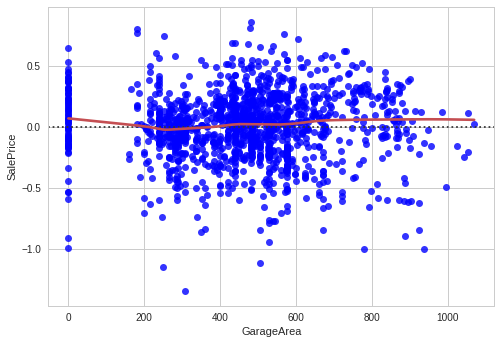

In [227]:
sns.residplot(X['GarageArea'], y, lowess=True, color="r", scatter_kws={'color':'blue'})

In [0]:
# Candidate for polynomial forms
X['LotFrontage_sq']=X['LotFrontage']**2
X['LotArea_sq']=X['LotArea']**2

In [229]:
# Statsmodel after polynomial forms fitting

model = sm.OLS(y, X).fit(cov_type='HC3')
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 4.095e+04
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        03:27:37   Log-Likelihood:                -2035.4
No. Observations:                1389   AIC:                             4089.
Df Residuals:                    1380   BIC:                             4136.
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
LotFrontage        0.2239      0.006     36.

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

In [0]:
##### Your Code Here #####

# Stretch Goals

- Research the assumptions that are required for OLS to be BLUE the "Best Linear Unbiased Estimator". You might try searching and trying to understand the conditions of what's called the Gauss-Markov Theorem.
- Research other Diagnostic tests. Can you show that residuals are normally distributed graphically?
- Study for the sprint challenge!
- Write a blog post about iferential modeling using linear regression.